In [1]:
from typing import List, Tuple
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
from jaxtyping import Key, Array
import optax 
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import trange

from model import InducedSelfAttentionBlock, MultiheadAttentionPooling
from mnist import image_to_point_cloud

In [2]:
key = jr.key(0)

dataset = torchvision.datasets.MNIST(
    root="~/MNIST",
    download=True,
    transform=torchvision.transforms.ToTensor()
)

n_data = 10_000 # Max = 60,000
use_density = True # Use pixel density information or not

# Probably a faster way of doing this but sets can be difficult
mnist_clouds = []
labels = []
idx = np.random.randint(0, len(dataset), (n_data,))
for i in trange(n_data):
    image, y = dataset[idx[i]]

    cloud = image_to_point_cloud(
        image,
        noise_scale=0.1,
        n_points_subsample=200,
        use_density=use_density
    )

    # Record the (x, y) points and the pixel density, plus label
    mnist_clouds.append(cloud)
    labels.append(y) # Do this on the side to avoid type casting

# Stack as arrays, assuming sets of equal cardinality here
X = np.stack(mnist_clouds)
Y = np.stack(labels) # Optax wants integers for loss

X = (X - X.mean(axis=0)) / X.std(axis=0)

X.shape, Y.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

((10000, 200, 3), (10000,))

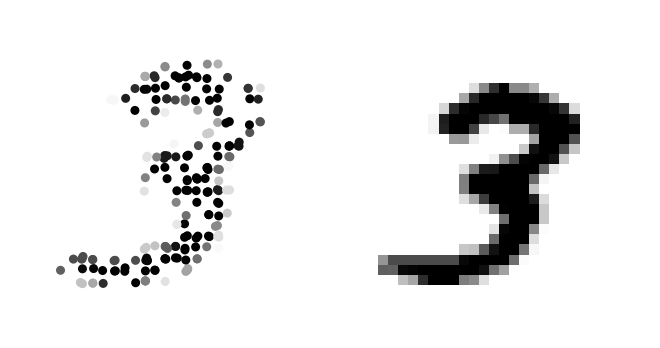

In [3]:
ix = np.random.randint(0, n_data)

cmap = "gray_r"
fig, ax = plt.subplots(1, 2, figsize=(4., 2.), dpi=200)
ax[0].scatter(
    *mnist_clouds[ix][:, :2].T, 
    c=mnist_clouds[ix][:, -1], 
    s=5.0, 
    cmap=cmap
)
ax[0].set_xlim(-1.4, 1.4)
ax[0].set_ylim(-1.4, 1.4)
ax[1].axis("off")
ax[1].imshow(dataset[idx[ix]][0].squeeze(), cmap=cmap)
ax[0].axis("off")
plt.show()

In [4]:
f = 0.8
Xt, Xv = np.split(X, [int(f * len(X))])
Yt, Yv = np.split(Y, [int(f * len(X))])

set_ds_train = TensorDataset(torch.as_tensor(Xt), torch.as_tensor(Yt))
set_ds_valid = TensorDataset(torch.as_tensor(Xv), torch.as_tensor(Yv))

In [5]:
class SetTransformer(eqx.Module):
    encoder: Tuple[InducedSelfAttentionBlock] 
    decoder: Tuple[
        MultiheadAttentionPooling, InducedSelfAttentionBlock
    ] 
    mlp: eqx.nn.MLP

    def __init__(
        self, 
        data_dim: int, 
        out_dim: int, 
        n_encoder_layers: int, 
        n_decoder_layers: int, 
        n_heads: int, 
        n_seeds: int, 
        n_inducing_points: int,
        hidden_dim: int, 
        *, 
        key: Key
    ):
        keys = jr.split(key, 4)

        dims = [data_dim] + [hidden_dim] * n_encoder_layers + [hidden_dim]
        layers = []
        for (_key, _in, _out) in zip(
            jr.split(keys[0], n_encoder_layers + 2), dims[:-1], dims[1:]
        ):
            layers.append(
                InducedSelfAttentionBlock(
                    _in, _out, n_heads, n_inducing_points, hidden_dim, key=_key
                )
            )
        self.encoder = tuple(layers)

        dims = [hidden_dim] + [hidden_dim] * n_decoder_layers + [hidden_dim]
        layers = [
            MultiheadAttentionPooling(
                hidden_dim, n_heads, n_seeds, hidden_dim, key=keys[1]
            )
        ]
        for (_key, _in, _out) in zip(
            jr.split(keys[2], n_decoder_layers + 2), dims[:-1], dims[1:]
        ):
            layers.append(
                InducedSelfAttentionBlock(
                    _in, _out, n_heads, n_inducing_points, hidden_dim, key=_key
                )
            )
        self.decoder = tuple(layers)
        self.mlp = eqx.nn.MLP(
            hidden_dim, 
            out_dim, 
            activation=jax.nn.gelu, 
            width_size=hidden_dim,
            depth=1,
            key=keys[3]
        )
    
    def __call__(self, x: Array) -> Array:
        for e in self.encoder:
            x = e(x)
        for d in self.decoder:
            x = d(x)
        return jax.vmap(self.mlp)(x)

In [6]:
n_epochs = 400
n_batch = 512
opt = optax.adam(learning_rate=1e-4)

n_data, n_set, data_dim = X.shape

model = SetTransformer(
    data_dim, 
    out_dim=10, # MNIST classification
    n_encoder_layers=3, 
    n_decoder_layers=3, 
    n_heads=1, 
    n_seeds=1, 
    n_inducing_points=32, 
    hidden_dim=64, 
    key=key
)

opt_state = opt.init(eqx.filter(model, eqx.is_array))


def loss(model, x, y):
    y_ = jax.vmap(model)(x).squeeze() # Seed dimension removed
    return optax.softmax_cross_entropy_with_integer_labels(y_, y).mean()


@eqx.filter_jit
def make_step(model, opt_state, x, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def eval(model, x, y):
    loss_value = loss(model, x, y)
    return loss_value


def prepare(x, y):
    return x.numpy(), y.numpy()


losses = []
with trange(n_epochs) as bar:
    set_dl_train = DataLoader(set_ds_train, batch_size=n_batch)
    set_dl_valid = DataLoader(set_ds_valid, batch_size=n_batch)

    for _ in bar:
        Lt = 0.
        for t, (x, y) in enumerate(set_dl_train):
            x, y = prepare(x, y)
            model, opt_state, _Lt = make_step(model, opt_state, x, y)
            Lt += _Lt

        Lv = 0.
        for v, (x, y) in enumerate(set_dl_valid):
            x, y = prepare(x, y)
            _Lv = eval(model, x, y)
            Lv += _Lv

        losses.append((Lt.item() / (t + 1), Lv.item() / (v + 1)))
        bar.set_postfix_str(f"{Lt=:.3E} {Lv=:.3E}")

  0%|          | 0/400 [00:00<?, ?it/s]

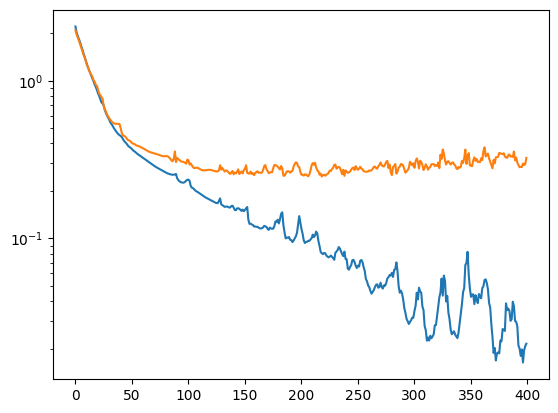

In [7]:
plt.semilogy(losses)
plt.show()

In [32]:
@eqx.filter_jit
def compute_accuracy(model, x, y):
    pred_y = jax.vmap(model)(x).squeeze()
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

ix = jr.randint(jr.fold_in(key, i), (4000,), 0, n_data)
x, y = X[ix], Y[ix]

accuracy = compute_accuracy(model, x, y)

"Accuracy=" + str(accuracy * 100.) + "%"

(4000,)


'Accuracy=97.77501%'

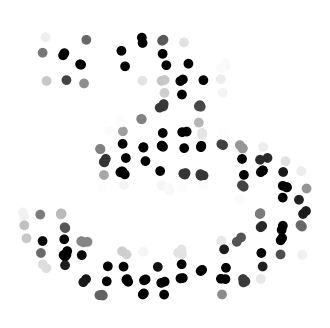

(3, 3)

In [48]:
ix = np.random.randint(0, n_data)

plt.figure(figsize=(4., 4.))
plt.scatter(*X[ix, :, :-1].T, c=X[ix, :, -1], cmap=cmap)
plt.axis("off")
plt.xlim(-2., 2.)
plt.ylim(-2., 2.)
plt.show()

jnp.argmax(model(X[ix])).item(), Y[ix].item()